In [1]:
%load_ext autoreload
%autoreload 2
# from src.vnc import run_vnc_simulation


import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
import jax
# jax.config.update("jax_enable_x64", True)
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"
import sparse

from src.optimized_vnc import *
from src.plot_utils import *


In [3]:
experiment='Stim_Neurons'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)




# experiment='default'
# with initialize(version_base=None, config_path="../configs"):
#     cfg_old=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
#     HydraConfig.instance().set_config(cfg_old)

# for k in cfg_old.paths.keys():
#     if (k != 'user'):
#         cfg_old.paths[k] = Path(cfg_old.paths[k])
#         cfg_old.paths[k].mkdir(parents=True, exist_ok=True)


In [7]:
# results = run_vnc_simulation_optimized(cfg)
# save_path = cfg.paths.ckpt_dir  / "bdn2.npz"

results = sparse.load_npz(cfg.paths.ckpt_dir  / "bdn2.npz").todense().astype(np.float32)

In [23]:
params, config = load_vnc_net(cfg)
simulator = OptimizedSimulator(params, config)


Pre-compiling JAX functions...
Compilation complete.


In [24]:
additional_param = jnp.array([0] * simulator.n_param_sets)
# Create expanded parameter arrays for all stimulus combinations
expanded_params = simulator._create_expanded_params(additional_param)

In [25]:
n_batches = 1
batch_size = 100
all_results = []
total_processed = 0

for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, simulator.total_combinations)
    actual_batch_size = end_idx - start_idx
    
    # Extract batch data
    batch_data = simulator._extract_batch_data_multi_stim(start_idx, end_idx, expanded_params)

In [3]:
params, config = load_vnc_net(cfg)

In [6]:
"""Load and configure VNC network parameters and simulation settings."""
validate_config(cfg)

W, W_table = load_connectivity(cfg)
sim_config = create_sim_config(cfg, W)



# stim_neurons = jnp.array(cfg.experiment.stimNeurons, dtype=jnp.int32)

newkey, subkey = jax.random.split(sim_config.rng_key)
newkey = jax.random.split(newkey, sim_config.num_sims)
tau, a, threshold, fr_cap = sample_neuron_parameters(cfg, sim_config.n_neurons, sim_config.num_sims, subkey)

if "size" in W_table:
    a, threshold = set_sizes(W_table["size"].values, a, threshold)
else:
    a, threshold = set_sizes(W_table["surf_area_um2"].values, a, threshold)

input_currents = jnp.stack([make_input(sim_config.n_neurons, jnp.array(stim_neurons, dtype=jnp.int32), sim_config.stim_input) for stim_neurons in cfg.experiment.stimNeurons], axis=0)
exc_dn_idxs, inh_dn_idxs, exc_in_idxs, inh_in_idxs, mn_idxs = extract_shuffle_indices(W_table)

params = NeuronConfig(
    W=W, W_table=W_table, tau=tau, a=a, threshold=threshold, fr_cap=fr_cap,
    input_currents=input_currents, seeds=newkey, stim_neurons=cfg.experiment.stimNeurons,
    exc_dn_idxs=exc_dn_idxs, inh_dn_idxs=inh_dn_idxs, exc_in_idxs=exc_in_idxs,
    inh_in_idxs=inh_in_idxs, mn_idxs=mn_idxs,
)

In [8]:
input_currents.shape, threshold.shape

((2, 4561), (200, 4561))

In [ ]:
W, W_table = load_connectivity(cfg)
# CHANGE DEFAULTS
allExcDNs = W_table.loc[(W_table["class"] == "descending neuron") & (W_table["predictedNt"] == "acetylcholine")]
stimNeurons = allExcDNs.index.to_list()
stimNeurons = [[neuron] for neuron in stimNeurons]
nSims = len(stimNeurons)

In [ ]:
from src.Archive.vnc_old import load_vnc_net as load_vnc_net_old
params, config = load_vnc_net(cfg)
params_old, config_old = load_vnc_net_old(cfg_old)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
for n, (orig,new) in enumerate(zip([params_old.tau,params_old.threshold,params_old.a,params_old.fr_cap], [params.tau, params.threshold, params.a, params.fr_cap])):
    axs[n].hist(orig.flatten(), bins=50, alpha=0.5, label='Sampled', density=True)
    axs[n].hist(new.flatten(), bins=50, alpha=0.5, label='Original', density=True)
    axs[n].set_title(f"Histogram of {n}")
    axs[n].set_xlabel(n)
    axs[n].set_ylabel("Frequency")

In [41]:
params, config = load_vnc_net(cfg)

In [97]:
batch_size = 200#2**6# cfg.experiment.batch_size
# batch_idx = 0  # Example batch index
work_queue = []
ntotal = 0
n_stim_configs = len(params.input_currents_list)
n_param_sets = n_replicates = 12345 # len(params.tau)
for stim_idx in range(n_stim_configs):
    for param_idx in range(n_param_sets):
        work_queue.append({"stim_idx":stim_idx, "param_idx":param_idx, "total_count": ntotal})
        ntotal +=1
all_results = []
all_metadata = []
n_batches = (len(work_queue) + batch_size - 1) // batch_size
for batch_idx in range(n_batches):
    start_idx = batch_idx * batch_size
    end_idx = min((batch_idx + 1) * batch_size, len(work_queue))
    actual_batch_size = end_idx - start_idx
    batch_work = work_queue[start_idx:end_idx]

    batch_params = {
        'tau_batch': jnp.array([item['total_count'] for item in batch_work]),
        'stim_batch': jnp.array([item['stim_idx'] for item in batch_work]),
        'param_batch': jnp.array([item['param_idx'] for item in batch_work])
    }

    batch_metadata = [
        {'param_idx': item['param_idx'], 'stim_idx': item['stim_idx'], 'total_count': item['total_count']} 
        for item in batch_work
    ]
    
    batch_size = len(batch_params['tau_batch'])
    n_devices = jax.device_count()
    # Pad to make divisible by n_devices
    pad_size = n_devices - (batch_size % n_devices) if batch_size % n_devices != 0 else 0
    print(pad_size, batch_size, n_devices)
    device_data = {}
    for key, data in batch_params.items():
    #     if pad_size > 0:
    #         # Pad with the last element
    #         if data.ndim == 1:
    #             padding = jnp.repeat(data[-1:], pad_size, axis=0)
    #         else:
    #             padding = jnp.repeat(data[-1:], pad_size, axis=0)
    #         data_padded = jnp.concatenate([data, padding])
    #     else:
    #         data_padded = data
        
        # Reshape for devices
        device_data[key] = data.reshape(n_devices, -1, *data.shape[1:])
    print(f"device_data: {device_data['tau_batch'].shape}, {device_data['stim_batch'].shape}, {device_data['param_batch'].shape}")


    batch_results = device_data['tau_batch'][:,:,None,None]
    batch_results_flat = batch_results.reshape(-1, *batch_results.shape[2:])
    batch_results_trimmed = batch_results_flat[:actual_batch_size]
    batch_results_trimmed = jax.device_put(batch_results_trimmed, jax.devices('cpu')[0])
    batch_results_trimmed = jnp.where(
            jnp.isinf(batch_results_trimmed) | jnp.isnan(batch_results_trimmed), 
            0, batch_results_trimmed
        )
    all_results.extend(batch_results_trimmed)
    all_metadata.extend(batch_metadata)
    print(f'batch:{batch_idx}, {batch_results_trimmed.squeeze()}')


0 200 2
device_data: (2, 100), (2, 100), (2, 100)
batch:0, [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199]
0 200 2
device_data: (2, 100), (2, 100), (2, 100)
batch:1, [200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 

16

In [85]:
batch_size % n_devices, batch_size, n_devices
# batch_params['tau_batch'], len(work_queue)

(0, 16, 2)

In [66]:

results_by_stim = {}
results_by_stim_total_ind = {}
# Initialize batch_results_trimmed containers
for stim_idx in range(n_stim_configs):
    results_by_stim[stim_idx] = [None] * n_param_sets
    results_by_stim_total_ind[stim_idx] = [None] * n_param_sets

# Place results in correct positions using metadata
for batch_results_trimmed, metadata in zip(all_results, all_metadata):
    param_idx = metadata['param_idx']
    stim_idx = metadata['stim_idx']
    
    # Validate indices
    if param_idx >= n_param_sets or stim_idx >= n_stim_configs:
        print(f"Warning: Invalid indices param_idx={param_idx}, stim_idx={stim_idx}")
        continue
    results_by_stim_total_ind[stim_idx][param_idx] = metadata['total_count']
    results_by_stim[stim_idx][param_idx] = batch_results_trimmed

# Convert to arrays and validate completeness
for stim_idx in results_by_stim:
    results_list = results_by_stim[stim_idx]
    result_inds = results_by_stim_total_ind[stim_idx]
    if (jnp.diff(jnp.array(results_by_stim_total_ind[stim_idx])) > 1).any():
        print(f"Warning: Inconsistent results for stimulus {stim_idx}, indices: {result_inds}")
    # Check for missing results
    missing_indices = [i for i, batch_results_trimmed in enumerate(results_list) if batch_results_trimmed is None]
    if missing_indices:
        print(f"Warning: Missing results for stimulus {stim_idx} at parameter indices: {missing_indices}")
        # Fill missing with zeros (same shape as other results)
        ref_shape = next(r.shape for r in results_list if r is not None)
        for idx in missing_indices:
            results_list[idx] = jnp.zeros(ref_shape)
    
    results_by_stim[stim_idx] = jnp.array(results_list)
results2 = jnp.stack([results_by_stim[n] for n in results_by_stim.keys()])


In [9]:
np.where(np.all(np.sum(results,axis=-1)==0,axis=-1))

(array([], dtype=int64), array([], dtype=int64))

In [8]:
results.shape

(2, 100, 4561, 2000)

0.058823526


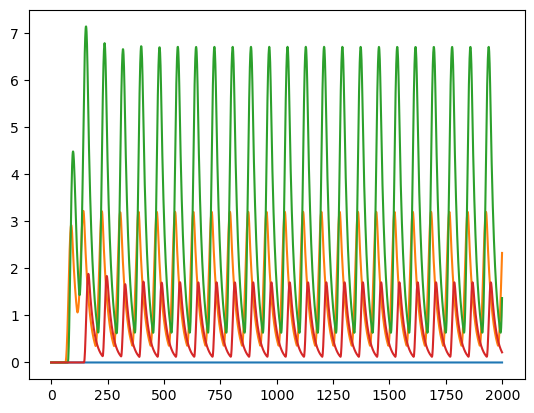

In [14]:
R = results[1][3]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
# for i in mnIdxs:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))


In [ ]:
from scipy import signal
import numpy as np
def neuron_oscillation_score_helper(activity,prominence):
    activity = activity-np.min(activity)
    activity = 2 * activity/np.max(activity) - 1

    autocorr = np.correlate(activity,activity,mode="full") / np.inner(activity,activity)
    lags = signal.correlation_lags(len(activity),len(activity))
    autocorr = autocorr[lags>0]
    lags = lags[lags>0]

    peaks, peakProperties = signal.find_peaks(autocorr,height=(None,None),prominence=prominence)
    if len(peaks) > 0:
        score = np.min([np.max(peakProperties["peak_heights"]),np.max(peakProperties["prominences"])])
        frequency = 1 / peaks[np.argmax(peakProperties["prominences"])]
    else:
        score = 0
        frequency = 0

    return score, frequency

def neuron_oscillation_score(activity,returnFrequency=False,prominence=0.05):
    rawScore, frequency = neuron_oscillation_score_helper(activity,prominence)
    # normalize to sine wave of the same frequency and duration
    if rawScore == 0:
        score = 0
    else:
        refSinScore, _ = neuron_oscillation_score_helper(np.sin(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refCosScore, _ = neuron_oscillation_score_helper(np.cos(2*np.pi*frequency*np.arange(len(activity))),prominence)
        refScore = np.max((refSinScore,refCosScore))
        score = rawScore / refScore

    if returnFrequency:
        return score, frequency
    else:
        return score

def sim_oscillation_score(R,activeMnIdxs,start=None,end=None,returnFrequency=False):
    """calculate oscillation score for a simulation"""
    if start is None:
        start = 0
    if end is None:
        end = -1

    if returnFrequency:
        neuronOscillationScores = []
        frequencies = []

        for j in activeMnIdxs:
            score, freq = neuron_oscillation_score(R[j][start:end],returnFrequency=True)
            neuronOscillationScores.append(score)
            frequencies.append(freq)

        return np.mean(neuronOscillationScores), np.nanmean(frequencies)
        
    else:
        neuronOscillationScores = [neuron_oscillation_score(R[j][start:end]) for j in activeMnIdxs] # scores for each neuron
        return np.mean(neuronOscillationScores) # average for the simulation
    
    

def run_with_stim_adjustment(self,maxIters=10,clampedNeurons=[],clampedRates=None,nActiveUpper=500,nActiveLower=5,nHighFrUpper=100):
    nextHighest = None
    nextLowest = None

    for i in range(maxIters):
        self.run(clampedNeurons=clampedNeurons,clampedRates=clampedRates)
        R = self.R

        nActive = sum(np.sum(R,1)>0)
        nHighFr = sum(np.max(R,1)>100)

        currInputs = self.inputs.copy()

        print(f"Run {i}")
        print(f"max stimI = {np.max(currInputs)}")
        print(f"nActive: {nActive}")
        print(f"nHighFr: {nHighFr}")

        if (nActive > nActiveUpper) or (nHighFr > nHighFrUpper): # too strong
            if nextLowest is None:
                newInputs = currInputs/2
            else:
                newInputs = (currInputs+nextLowest)/2
            nextHighest = currInputs
        elif (nActive < nActiveLower): # too weak
            if nextHighest is None:
                newInputs = currInputs*2
            else:
                newInputs = (currInputs+nextHighest)/2
            nextLowest = currInputs
        else:
            break

        self.set_input(newInputs)